In [12]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
# Suppress warnings
warnings.filterwarnings("ignore")

# File path for the Excel file
file_path = "SasExcelReport_TAF_PMTCT_V1.0_2024_10_12_09_22.xls"

# Load valid USUBJIDs from the 'LB10' sheet and remove duplicates
ids = pd.read_excel(file_path, sheet_name="LB10")["USUBJID"].drop_duplicates().reset_index(drop=True)

# Exclude specific IDs
exclude_ids = {"05-026", "05-010", "07-011", "01-047", "05-014", "03-012", "12-007", "02-012", "02-013", "01-053"}
filtered_ids = ids[~ids.isin(exclude_ids)].reset_index(drop=True)
print('需要提取的ID是:',len(filtered_ids))

# Function to extract ALT or AST data
def extract_laboratory_data(sheetname,variable,value_col,name_col,name_code, visit_types):
    lb2_df = pd.read_excel(file_path, sheet_name=sheetname)
    data = lb2_df[
        (lb2_df["USUBJID"].isin(filtered_ids)) &
        (lb2_df["VISIT"].isin(visit_types)) &
        (lb2_df[name_col] == name_code)
    ][["USUBJID", value_col]].dropna(subset=[value_col]).drop_duplicates(subset="USUBJID", keep='first')

    # Clean and convert "LBORRES" to numeric
    data[value_col] = data[value_col].replace(r"[＞><＜]", "", regex=True)
    data[value_col] = data[value_col].replace(['ND', 'UK', 'uk', 'NA', 'na', '-'], np.nan).astype(float)
    return data.dropna(subset=[value_col]).rename(columns={value_col: variable})

# Extract ALT and AST data
baseline_visit_types = ["筛选访视（孕24-26周）", "筛选访视（孕24-26周）(2)"]
delivery_visit_types = ["分娩访视", "分娩访视(2)"]
ppm28w_visit_types = ['产后访视3（分娩后28-30周）(2)','产后访视3（分娩后28-30周）']

baseline_alt = extract_laboratory_data(sheetname="LB2",variable="ALT",value_col="LBORRES",name_col="LBTESTCD", name_code='谷丙转氨酶（ALT）', visit_types=baseline_visit_types)
delivery_alt = extract_laboratory_data(sheetname="LB2",variable="ALT",value_col="LBORRES",name_col="LBTESTCD", name_code='谷丙转氨酶（ALT）', visit_types=delivery_visit_types)

baseline_ast = extract_laboratory_data(sheetname="LB2",variable="AST",value_col="LBORRES",name_col="LBTESTCD", name_code='谷草转氨酶（AST）', visit_types=baseline_visit_types)
delivery_ast = extract_laboratory_data(sheetname="LB2",variable="AST",value_col="LBORRES",name_col="LBTESTCD", name_code='谷草转氨酶（AST）', visit_types=delivery_visit_types)

baseline_hbv = extract_laboratory_data(sheetname="LB10",variable="HBV",value_col="结果",name_col="检查项目", name_code='HBV DNA', visit_types=baseline_visit_types)
baseline_hbv["HBV"]=np.log10(baseline_hbv["HBV"])
delivery_hbv = extract_laboratory_data(sheetname="LB10",variable="HBV",value_col="结果",name_col="检查项目", name_code='HBV DNA', visit_types=delivery_visit_types)
delivery_hbv["HBV"]=np.log10(delivery_hbv["HBV"])

baseline_hbsag = extract_laboratory_data(sheetname="LB9",variable="HBsAg",value_col="结果",name_col="检查项目", name_code='HBsAg', visit_types=baseline_visit_types)
baseline_hbsag["HBsAg"]=np.log10(baseline_hbsag["HBsAg"])
ppm28w_hbsag = extract_laboratory_data(sheetname="LB12",variable="HBsAg",value_col="结果",name_col="检查项目", name_code='HBsAg', visit_types=ppm28w_visit_types)
ppm28w_hbsag["HBsAg"]=np.log10(ppm28w_hbsag["HBsAg"])
t_statistic, p_value = stats.ttest_ind(baseline_hbsag["HBsAg"].dropna(), ppm28w_hbsag["HBsAg"].dropna(), equal_var=False)
# Results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

baseline_hbeag = extract_laboratory_data(sheetname="LB9",variable="HBeAg",value_col="结果",name_col="检查项目", name_code='HBeAg', visit_types=baseline_visit_types)
baseline_hbeag["HBeAg"]=np.log10(baseline_hbeag["HBeAg"])
ppm28w_hbeag = extract_laboratory_data(sheetname="LB12",variable="HBeAg",value_col="结果",name_col="检查项目", name_code='HBeAg', visit_types=ppm28w_visit_types)
ppm28w_hbeag["HBeAg"]=np.log10(ppm28w_hbeag["HBeAg"])
t_statistic, p_value = stats.ttest_ind(baseline_hbeag["HBeAg"], ppm28w_hbeag["HBeAg"], equal_var=False)
# Results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Calculating mean and standardized deviation
def calculate_stats(data):
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # Using sample standard deviation
    return mean, std_dev

# Calculate stats for ALT
mean_baseline_alt, std_dev_baseline_alt = calculate_stats(baseline_alt["ALT"])
mean_delivery_alt, std_dev_delivery_alt = calculate_stats(delivery_alt["ALT"])

# Calculate stats for AST
mean_baseline_ast, std_dev_baseline_ast = calculate_stats(baseline_ast["AST"])
mean_delivery_ast, std_dev_delivery_ast = calculate_stats(delivery_ast["AST"])

# Calculate stats for HBV
mean_baseline_hbv, std_dev_baseline_hbv = calculate_stats(baseline_hbv["HBV"])
mean_delivery_hbv, std_dev_delivery_hbv = calculate_stats(delivery_hbv["HBV"])

# Calculate stats for HBsAg
mean_baseline_hbsag, std_dev_baseline_hbsag = calculate_stats(baseline_hbsag["HBsAg"])
mean_ppm28w_hbsag, std_dev_ppm28w_hbsag = calculate_stats(ppm28w_hbsag["HBsAg"])

# Calculate stats for HBeAg
mean_baseline_hbeag, std_dev_baseline_hbeag = calculate_stats(baseline_hbeag["HBeAg"])
mean_ppm28w_hbeag, std_dev_ppm28w_hbeag = calculate_stats(ppm28w_hbeag["HBeAg"])

print(mean_baseline_alt, std_dev_baseline_alt,'\n',
      mean_delivery_alt, std_dev_delivery_alt,'\n',
      mean_baseline_ast, std_dev_baseline_ast ,'\n',
      mean_delivery_ast, std_dev_delivery_ast,'\n',
      mean_baseline_hbv, std_dev_baseline_hbv,'\n',
      mean_delivery_hbv, std_dev_delivery_hbv,'\n',
      mean_baseline_hbsag, std_dev_baseline_hbsag,'\n',
      mean_ppm28w_hbsag, std_dev_ppm28w_hbsag,'\n',
      mean_baseline_hbeag, std_dev_baseline_hbeag,'\n',
      mean_ppm28w_hbeag, std_dev_ppm28w_hbeag)

需要提取的ID是: 226
T-statistic: -1.1071329473834277
P-value: 0.2690368733245655
T-statistic: 3.3264826655920685
P-value: 0.0010172070628370314
18.220355555555557 7.489690763319854 
 16.291269035532995 9.802948323352105 
 20.107511111111112 5.558127818717948 
 22.080414507772023 7.42342785223164 
 7.9494929472791425 0.6105372701731249 
 4.168286362449003 0.9621210508129158 
 4.501248066269088 0.4450247965475982 
 4.557547666053212 0.5485310936643671 
 3.1044578493896333 0.2985310079635885 
 2.9384302558015722 0.6074772956626875


In [13]:
import pandas as pd

# Process ALT data
data_alt = pd.concat([
    baseline_alt.assign(Group='Baseline'),
    delivery_alt.assign(Group='Delivery')
], ignore_index=True).drop(columns=['USUBJID'], errors='ignore')[['Group', 'ALT']]

# Save data_alt to a .txt file without column names and index
output_path = r"D:/OneDrive/8.Jinlin hou/刘志华/20240930TAF项目/figures/data_alt.txt"
data_alt.to_csv(output_path, sep='\t', header=False, index=False)


# Process AST data
data_ast = pd.concat([
    baseline_ast.assign(Group='Baseline'),
    delivery_ast.assign(Group='Delivery')
], ignore_index=True).drop(columns=['USUBJID'], errors='ignore')[['Group', 'AST']]
output_path = r"D:/OneDrive/8.Jinlin hou/刘志华/20240930TAF项目/figures/data_ast.txt"
data_ast.to_csv(output_path, sep='\t', header=False, index=False)

# Process HBV data
data_hbv = pd.concat([
    baseline_hbv.assign(Group='Baseline'),
    delivery_hbv.assign(Group='Delivery')
], ignore_index=True).drop(columns=['USUBJID'], errors='ignore')[['Group', 'HBV']]
output_path = r"D:/OneDrive/8.Jinlin hou/刘志华/20240930TAF项目/figures/data_hbv.txt"
data_hbv.to_csv(output_path, sep='\t', header=False, index=False)

# Process HBsAg data
data_hbsag = pd.concat([
    baseline_hbsag.assign(Group='Baseline'),
    ppm28w_hbsag.assign(Group='PPM28W')
], ignore_index=True).drop(columns=['USUBJID'], errors='ignore')[['Group', 'HBsAg']]
output_path = r"D:/OneDrive/8.Jinlin hou/刘志华/20240930TAF项目/figures/data_hbsag.txt"
data_hbsag.to_csv(output_path, sep='\t', header=False, index=False)

# Process HBeAg data
data_hbeag = pd.concat([
    baseline_hbeag.assign(Group='Baseline'),
    ppm28w_hbeag.assign(Group='PPM28W')
], ignore_index=True).drop(columns=['USUBJID'], errors='ignore')[['Group', 'HBeAg']]
output_path = r"D:/OneDrive/8.Jinlin hou/刘志华/20240930TAF项目/figures/data_hbeag.txt"
data_hbeag.to_csv(output_path, sep='\t', header=False, index=False)

Mann-Whitney U test结果: U-statistic=28079.0, p-value=2.179842918009097e-06


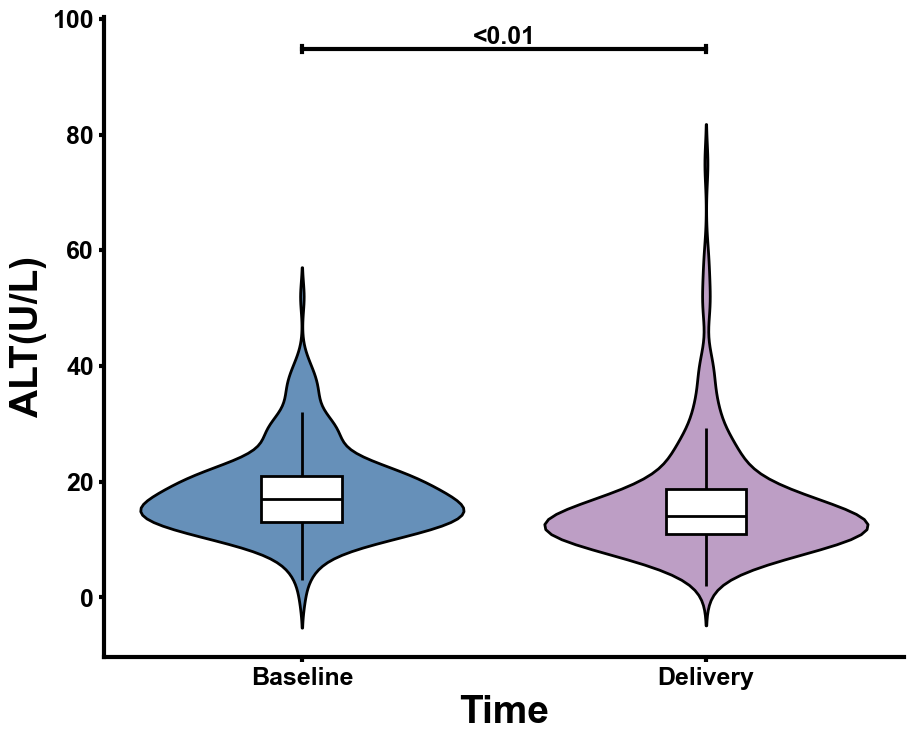

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu, normaltest

# Define colors
colors = ["#00468B99", "#925E9F99"]  # Removed the white color for striped bar

# Set the figure size and font properties
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'bold'  # Bold font

# Thicker border for the plot and ticks
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create the violin plot
sns.violinplot(data=data_alt, 
               x="Group", 
               y="ALT", 
               hue=None,
               palette=colors, 
               saturation=1,
               fill=True,
               inner=None,  # Remove the default inner box
               linewidth=2,
               linecolor="black",
               legend=False,
               dodge=False,  # Ensure the violins are not dodged
               ax=ax)

# Overlay the box plot with a narrower box
sns.boxplot(data=data_alt, 
            x="Group",
            y="ALT", 
            hue=None,
            palette=["#FFFFFF"],  # White color for the box
            fill=True,
            gap=0,
            linewidth=2,
            linecolor="black",
            width=0.2,  # Adjust the width of the box to make it narrower
            showfliers=False,  # Hide outliers
            showcaps=False,  # Hide the end lines (caps)
            legend=False,  # Ensure the box plot is on top
            zorder=10,  # Ensure the box plot is on top
            dodge=False,  # Ensure the box plot aligns with the violin plot
            ax=ax)

# Set the x-axis and y-axis labels with font size 28 and bold
ax.set_xlabel("Time", fontsize=28, weight='bold')
ax.set_ylabel("ALT(U/L)", fontsize=28, weight='bold')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# group1_data 和 group2_data 分别代表两组的数据
group1_data = data_alt[data_alt['Group'] == 'Baseline']['ALT']
group2_data = data_alt[data_alt['Group'] == 'Delivery']['ALT']

# 检查数据是否符合正态分布
k2_group1, p_group1 = stats.normaltest(group1_data)
k2_group2, p_group2 = stats.normaltest(group2_data)

alpha = 0.05  # 显著性水平

# 判断是否符合正态分布
is_normal_group1 = p_group1 > alpha
is_normal_group2 = p_group2 > alpha

if is_normal_group1 and is_normal_group2:
    # 如果两组数据都符合正态分布，则使用独立样本t检验
    t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
    print(f"独立样本t检验结果: t-statistic={t_stat}, p-value={p_value}")
else:
    # 如果任一组数据不符合正态分布，则使用Mann-Whitney U test
    u_stat, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
    print(f"Mann-Whitney U test结果: U-statistic={u_stat}, p-value={p_value}")


# 在图中添加横线和 p 值标签
y_max = ax.get_ylim()[1] * 1.1  # 获取 y 轴的最大值并增加一些空间
x1, x2 = 0, 1  # Group1 和 Group2 的索引
ax.plot([x1, x1, x2, x2], [y_max, y_max+0.05, y_max+0.05, y_max], lw=3, c="black")
# 添加端线
line_height = 0.005 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # 计算线的高度
ax.plot([x1, x1], [y_max - line_height, y_max + line_height], lw=3, c="black")
ax.plot([x2, x2], [y_max - line_height, y_max + line_height], lw=3, c="black")

# 根据p_value的值决定显示内容
if p_value < 0.01:
    display_p_value = "<0.01"
else:
    display_p_value = f"{p_value:.2f}"
ax.text((x1 + x2) / 2, y_max + 0.05, display_p_value, ha='center', va='bottom', fontsize=18, weight='bold')

# Adjust the subplot parameters to reduce margins
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

# Show the plot
plt.savefig('ALT.pdf',dpi=1200)

Mann-Whitney U test结果: U-statistic=18602.5, p-value=0.011487465888491286


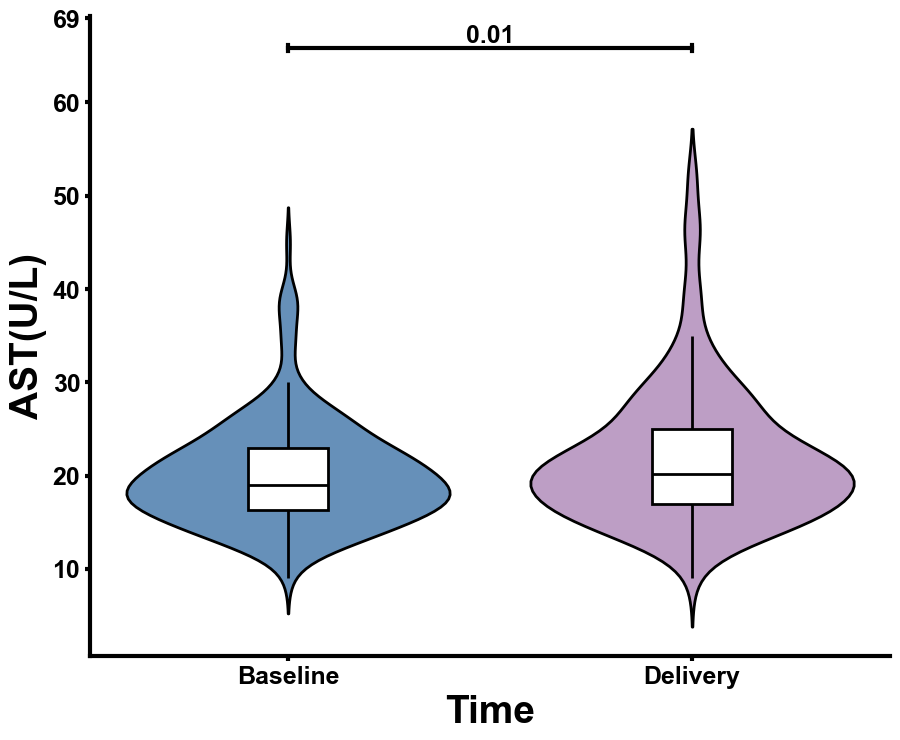

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu, normaltest

# Define colors
colors = ["#00468B99", "#925E9F99"]  # Removed the white color for striped bar

# Set the figure size and font properties
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'bold'  # Bold font

# Thicker border for the plot and ticks
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create the violin plot
sns.violinplot(data=data_ast, 
               x="Group", 
               y="AST", 
               hue=None,
               palette=colors, 
               saturation=1,
               fill=True,
               inner=None,  # Remove the default inner box
               linewidth=2,
               linecolor="black",
               legend=False,
               dodge=False,  # Ensure the violins are not dodged
               ax=ax)

# Overlay the box plot with a narrower box
sns.boxplot(data=data_ast, 
            x="Group",
            y="AST", 
            hue=None,
            palette=["#FFFFFF"],  # White color for the box
            fill=True,
            gap=0,
            linewidth=2,
            linecolor="black",
            width=0.2,  # Adjust the width of the box to make it narrower
            showfliers=False,  # Hide outliers
            showcaps=False,  # Hide the end lines (caps)
            legend=False,  # Ensure the box plot is on top
            zorder=10,  # Ensure the box plot is on top
            dodge=False,  # Ensure the box plot aligns with the violin plot
            ax=ax)

# Set the x-axis and y-axis labels with font size 28 and bold
ax.set_xlabel("Time", fontsize=28, weight='bold')
ax.set_ylabel("AST(U/L)", fontsize=28, weight='bold')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# group1_data 和 group2_data 分别代表两组的数据
group1_data = data_ast[data_ast['Group'] == 'Baseline']['AST']
group2_data = data_ast[data_ast['Group'] == 'Delivery']['AST']

# 检查数据是否符合正态分布
k2_group1, p_group1 = stats.normaltest(group1_data)
k2_group2, p_group2 = stats.normaltest(group2_data)

alpha = 0.05  # 显著性水平

# 判断是否符合正态分布
is_normal_group1 = p_group1 > alpha
is_normal_group2 = p_group2 > alpha

if is_normal_group1 and is_normal_group2:
    # 如果两组数据都符合正态分布，则使用独立样本t检验
    t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
    print(f"独立样本t检验结果: t-statistic={t_stat}, p-value={p_value}")
else:
    # 如果任一组数据不符合正态分布，则使用Mann-Whitney U test
    u_stat, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
    print(f"Mann-Whitney U test结果: U-statistic={u_stat}, p-value={p_value}")

# 在图中添加横线和 p 值标签
y_max = ax.get_ylim()[1] * 1.1  # 获取 y 轴的最大值并增加一些空间
x1, x2 = 0, 1  # Group1 和 Group2 的索引
ax.plot([x1, x1, x2, x2], [y_max, y_max+0.05, y_max+0.05, y_max], lw=3, c="black")
ax.set_yticks([10,20,30,40,50,60,69])
# 添加端线
line_height = 0.005 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # 计算线的高度
ax.plot([x1, x1], [y_max - line_height, y_max + line_height], lw=3, c="black")
ax.plot([x2, x2], [y_max - line_height, y_max + line_height], lw=3, c="black")

# 根据p_value的值决定显示内容
if p_value < 0.01:
    display_p_value = "<0.01"
else:
    display_p_value = f"{p_value:.2f}"
ax.text((x1 + x2) / 2, y_max + 0.05, display_p_value, ha='center', va='bottom', fontsize=18, weight='bold')

# Adjust the subplot parameters to reduce margins
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

# Show the plot
plt.savefig('AST.pdf',dpi=1200)

Mann-Whitney U test结果: U-statistic=45768.0, p-value=6.509779692943783e-71


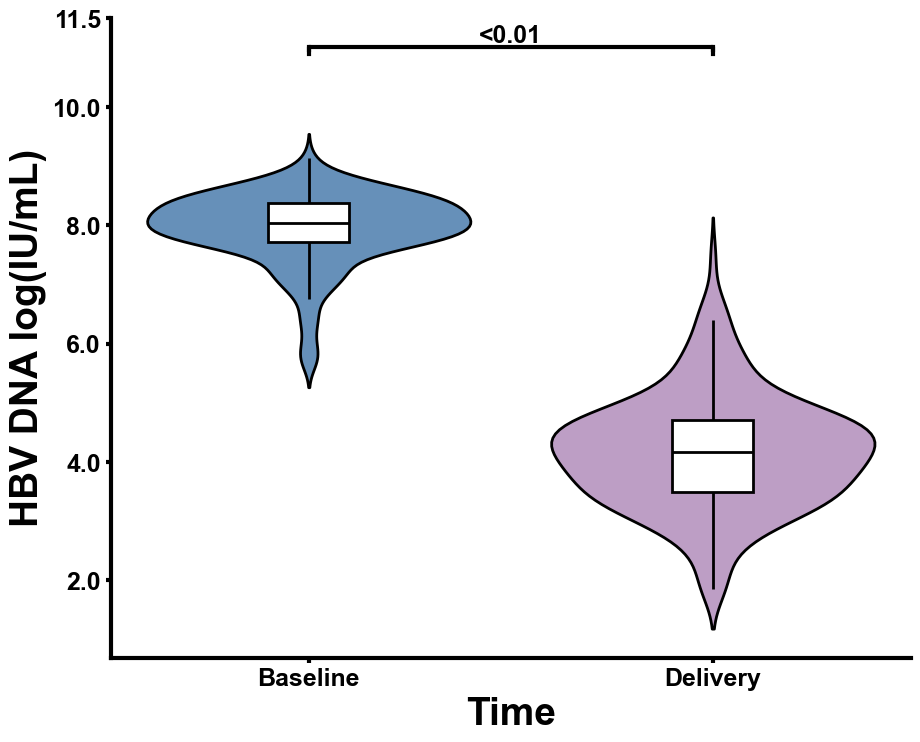

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu, normaltest

# Define colors
colors = ["#00468B99", "#925E9F99"]  # Removed the white color for striped bar

# Set the figure size and font properties
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'bold'  # Bold font

# Thicker border for the plot and ticks
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create the violin plot
sns.violinplot(data=data_hbv, 
               x="Group", 
               y="HBV", 
               hue=None,
               palette=colors, 
               saturation=1,
               fill=True,
               inner=None,  # Remove the default inner box
               linewidth=2,
               linecolor="black",
               legend=False,
               dodge=False,  # Ensure the violins are not dodged
               ax=ax)

# Overlay the box plot with a narrower box
sns.boxplot(data=data_hbv, 
            x="Group",
            y="HBV", 
            hue=None,
            palette=["#FFFFFF"],  # White color for the box
            fill=True,
            gap=0,
            linewidth=2,
            linecolor="black",
            width=0.2,  # Adjust the width of the box to make it narrower
            showfliers=False,  # Hide outliers
            showcaps=False,  # Hide the end lines (caps)
            legend=False,  # Ensure the box plot is on top
            zorder=10,  # Ensure the box plot is on top
            dodge=False,  # Ensure the box plot aligns with the violin plot
            ax=ax)

# Set the x-axis and y-axis labels with font size 28 and bold
ax.set_xlabel("Time", fontsize=28, weight='bold')
ax.set_ylabel("HBV DNA log(IU/mL)", fontsize=28, weight='bold')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# group1_data 和 group2_data 分别代表两组的数据
group1_data = data_hbv[data_hbv['Group'] == 'Baseline']['HBV']
group2_data = data_hbv[data_hbv['Group'] == 'Delivery']['HBV']

# 检查数据是否符合正态分布
k2_group1, p_group1 = stats.normaltest(group1_data)
k2_group2, p_group2 = stats.normaltest(group2_data)

alpha = 0.05  # 显著性水平

# 判断是否符合正态分布
is_normal_group1 = p_group1 > alpha
is_normal_group2 = p_group2 > alpha

if is_normal_group1 and is_normal_group2:
    # 如果两组数据都符合正态分布，则使用独立样本t检验
    t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
    print(f"独立样本t检验结果: t-statistic={t_stat}, p-value={p_value}")
else:
    # 如果任一组数据不符合正态分布，则使用Mann-Whitney U test
    u_stat, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
    print(f"Mann-Whitney U test结果: U-statistic={u_stat}, p-value={p_value}")

# 在图中添加横线和 p 值标签
y_max = ax.get_ylim()[1] * 1.1  # 获取 y 轴的最大值并增加一些空间
x1, x2 = 0, 1  # Group1 和 Group2 的索引
ax.plot([x1, x1, x2, x2], [y_max, y_max+0.05, y_max+0.05, y_max], lw=3, c="black")
ax.set_yticks([0,2,4,6,8,10,11.5])
# 添加端线
line_height = 0.005 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # 计算线的高度
ax.plot([x1, x1], [y_max - line_height, y_max + line_height], lw=3, c="black")
ax.plot([x2, x2], [y_max - line_height, y_max + line_height], lw=3, c="black")

# 根据p_value的值决定显示内容
if p_value < 0.01:
    display_p_value = "<0.01"
else:
    display_p_value = f"{p_value:.2f}"
ax.text((x1 + x2) / 2, y_max + 0.05, display_p_value, ha='center', va='bottom', fontsize=18, weight='bold')

# Adjust the subplot parameters to reduce margins
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

# Show the plot
plt.savefig('HBV.pdf',dpi=1200)

独立样本t检验结果: t-statistic=-1.1359641298647574, p-value=0.2566517180255531


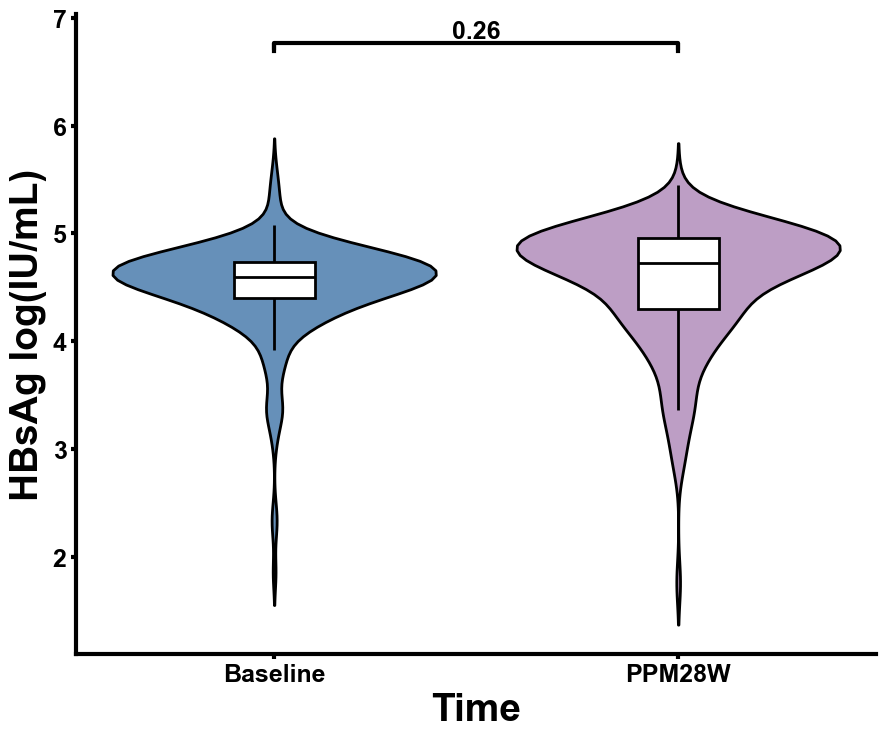

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu, normaltest

# Define colors
colors = ["#00468B99", "#925E9F99"]  # Removed the white color for striped bar

# Set the figure size and font properties
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'bold'  # Bold font

# Thicker border for the plot and ticks
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create the violin plot
sns.violinplot(data=data_hbsag, 
               x="Group", 
               y="HBsAg", 
               hue=None,
               palette=colors, 
               saturation=1,
               fill=True,
               inner=None,  # Remove the default inner box
               linewidth=2,
               linecolor="black",
               legend=False,
               dodge=False,  # Ensure the violins are not dodged
               ax=ax)

# Overlay the box plot with a narrower box
sns.boxplot(data=data_hbsag, 
            x="Group",
            y="HBsAg", 
            hue=None,
            palette=["#FFFFFF"],  # White color for the box
            fill=True,
            gap=0,
            linewidth=2,
            linecolor="black",
            width=0.2,  # Adjust the width of the box to make it narrower
            showfliers=False,  # Hide outliers
            showcaps=False,  # Hide the end lines (caps)
            legend=False,  # Ensure the box plot is on top
            zorder=10,  # Ensure the box plot is on top
            dodge=False,  # Ensure the box plot aligns with the violin plot
            ax=ax)

# Set the x-axis and y-axis labels with font size 28 and bold
ax.set_xlabel("Time", fontsize=28, weight='bold')
ax.set_ylabel("HBsAg log(IU/mL)", fontsize=28, weight='bold')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# group1_data 和 group2_data 分别代表两组的数据
group1_data = data_hbsag[data_hbsag['Group'] == 'Baseline']['HBsAg']
group2_data = data_hbsag[data_hbsag['Group'] == 'PPM28W']['HBsAg']

# 检查数据是否符合正态分布
k2_group1, p_group1 = stats.normaltest(group1_data)
k2_group2, p_group2 = stats.normaltest(group2_data)

alpha = 0.05  # 显著性水平

# 判断是否符合正态分布
is_normal_group1 = p_group1 > alpha
is_normal_group2 = p_group2 > alpha

#if is_normal_group1 and is_normal_group2:
    # 如果两组数据都符合正态分布，则使用独立样本t检验
t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
print(f"独立样本t检验结果: t-statistic={t_stat}, p-value={p_value}")
#else:
    # 如果任一组数据不符合正态分布，则使用Mann-Whitney U test
#    u_stat, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
#    print(f"Mann-Whitney U test结果: U-statistic={u_stat}, p-value={p_value}")

# 在图中添加横线和 p 值标签
y_max = ax.get_ylim()[1] * 1.1  # 获取 y 轴的最大值并增加一些空间
x1, x2 = 0, 1  # Group1 和 Group2 的索引
ax.plot([x1, x1, x2, x2], [y_max, y_max+0.05, y_max+0.05, y_max], lw=3, c="black")
# 添加端线
line_height = 0.005 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # 计算线的高度
ax.plot([x1, x1], [y_max - line_height, y_max + line_height], lw=3, c="black")
ax.plot([x2, x2], [y_max - line_height, y_max + line_height], lw=3, c="black")

# 根据p_value的值决定显示内容
if p_value < 0.01:
    display_p_value = "<0.01"
else:
    display_p_value = f"{p_value:.2f}"
ax.text((x1 + x2) / 2, y_max + 0.05, display_p_value, ha='center', va='bottom', fontsize=18, weight='bold')

# Adjust the subplot parameters to reduce margins
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

# Show the plot
plt.savefig('HBsAg.pdf',dpi=1200)

独立样本t检验结果: t-statistic=3.5903766563770754, p-value=0.0003712440402540915


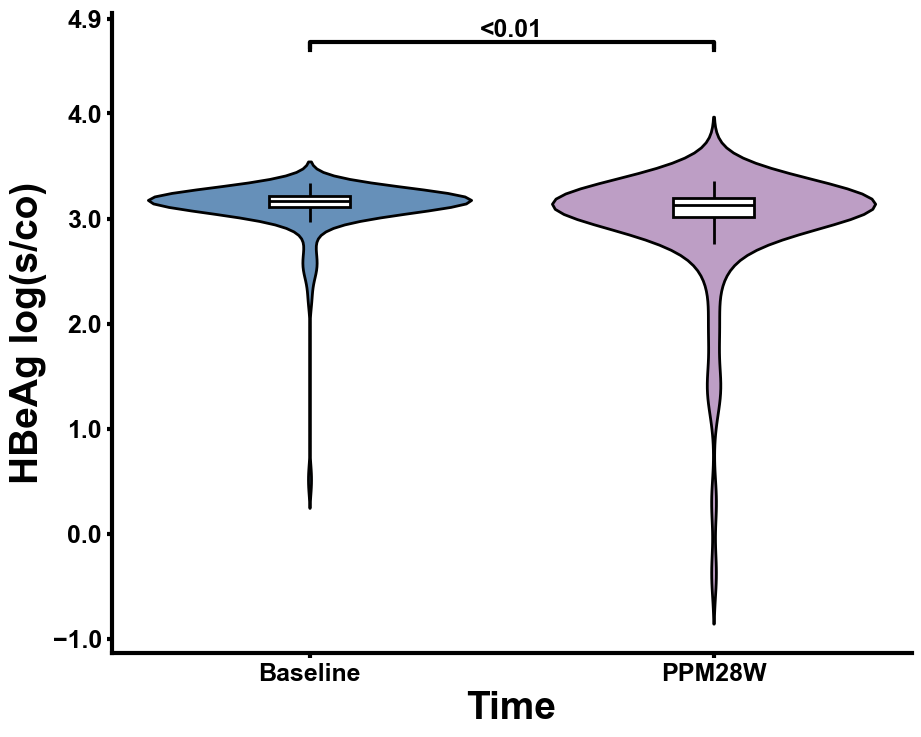

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu, normaltest

# Define colors
colors = ["#00468B99", "#925E9F99"]  # Removed the white color for striped bar

# Set the figure size and font properties
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'bold'  # Bold font

# Thicker border for the plot and ticks
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create the violin plot
sns.violinplot(data=data_hbeag, 
               x="Group", 
               y="HBeAg", 
               hue=None,
               palette=colors, 
               saturation=1,
               fill=True,
               inner=None,  # Remove the default inner box
               linewidth=2,
               linecolor="black",
               legend=False,
               dodge=False,  # Ensure the violins are not dodged
               ax=ax)

# Overlay the box plot with a narrower box
sns.boxplot(data=data_hbeag, 
            x="Group",
            y="HBeAg", 
            hue=None,
            palette=["#FFFFFF"],  # White color for the box
            fill=True,
            gap=0,
            linewidth=2,
            linecolor="black",
            width=0.2,  # Adjust the width of the box to make it narrower
            showfliers=False,  # Hide outliers
            showcaps=False,  # Hide the end lines (caps)
            legend=False,  # Ensure the box plot is on top
            zorder=10,  # Ensure the box plot is on top
            dodge=False,  # Ensure the box plot aligns with the violin plot
            ax=ax)

# Set the x-axis and y-axis labels with font size 28 and bold
ax.set_xlabel("Time", fontsize=28, weight='bold')
ax.set_ylabel("HBeAg log(s/co)", fontsize=28, weight='bold')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# group1_data 和 group2_data 分别代表两组的数据
group1_data = data_hbeag[data_hbeag['Group'] == 'Baseline']['HBeAg']
group2_data = data_hbeag[data_hbeag['Group'] == 'PPM28W']['HBeAg']

# 检查数据是否符合正态分布
k2_group1, p_group1 = stats.normaltest(group1_data)
k2_group2, p_group2 = stats.normaltest(group2_data)

alpha = 0.05  # 显著性水平

# 判断是否符合正态分布
is_normal_group1 = p_group1 > alpha
is_normal_group2 = p_group2 > alpha

#if is_normal_group1 and is_normal_group2:
    # 如果两组数据都符合正态分布，则使用独立样本t检验
t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
print(f"独立样本t检验结果: t-statistic={t_stat}, p-value={p_value}")
#else:
    # 如果任一组数据不符合正态分布，则使用Mann-Whitney U test
#   u_stat, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
#    print(f"Mann-Whitney U test结果: U-statistic={u_stat}, p-value={p_value}")

# 在图中添加横线和 p 值标签
y_max = ax.get_ylim()[1] * 1.1  # 获取 y 轴的最大值并增加一些空间
x1, x2 = 0, 1  # Group1 和 Group2 的索引
ax.plot([x1, x1, x2, x2], [y_max, y_max+0.05, y_max+0.05, y_max], lw=3, c="black")
ax.set_yticks([-1, 0, 1, 2, 3, 4, 4.9])
# 添加端线
line_height = 0.005 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # 计算线的高度
ax.plot([x1, x1], [y_max - line_height, y_max + line_height], lw=3, c="black")
ax.plot([x2, x2], [y_max - line_height, y_max + line_height], lw=3, c="black")

# 根据p_value的值决定显示内容
if p_value < 0.01:
    display_p_value = "<0.01"
else:
    display_p_value = f"{p_value:.2f}"
ax.text((x1 + x2) / 2, y_max + 0.05, display_p_value, ha='center', va='bottom', fontsize=18, weight='bold')

# Adjust the subplot parameters to reduce margins
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

# Show the plot
plt.savefig('HBeAg.pdf',dpi=1200)